- coisas para add 
    - data augmentation DONE 
    - matriz de confusao  
    - acuracia ao longo do tempo 
    - nova ativacao(leaky relu) 
    - tamanho dos modelos e arquiteura final 

# Imports

In [45]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import optuna 

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

import seaborn as sns

# Helper functions and MLP class

In [27]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation_function, dropout_rate, use_batch_norm=True):
        super(MLP, self).__init__()
        self.activation_function = activation_function
        self.dropout = nn.Dropout(p=dropout_rate)
        self.use_batch_norm = use_batch_norm

        layers_dims = [input_size] + hidden_layers + [num_classes]
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(len(layers_dims) - 1):  
            self.layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))
            
            if use_batch_norm and i < len(layers_dims) - 2:
                self.batch_norms.append(nn.BatchNorm1d(layers_dims[i+1]))



    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))
            x = self.dropout(x)

        x = self.layers[-1](x)
        
        return x 

In [28]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

def show_predictions(model, dataloader, num_samples):
    model.eval()
    correct_samples = []
    wrong_samples = []

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for images, labels in dataloader:
            original_images = images

            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                pred = predicted[i].cpu().item()
                true = labels[i].cpu().item()
                img = original_images[i]

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append((img, pred, true))
                elif pred != true and len(wrong_samples) < num_samples:
                    wrong_samples.append((img, pred, true))

                if len(correct_samples) >= num_samples and len(wrong_samples) >= num_samples:
                    break

    plt.figure(figsize=(24, 20))
    
    plt.subplot(1, 2, 1)
    # acertos
    for idx, (img, pred, true) in enumerate(correct_samples):
        plt.subplot(2, num_samples, idx + 1)
        img = img.permute(1, 2, 0)  
        img = img * 0.5 + 0.5 
        plt.imshow(img)
        plt.title(f'Correto!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')

    # erros
    for idx, (img, pred, true) in enumerate(wrong_samples):
        plt.subplot(2, num_samples, idx + num_samples + 1)
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        plt.imshow(img)
        plt.title(f'Erro!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')
    
    plt.tight_layout(h_pad=2)
    plt.show()

    return None

def objective(trial):
    global train_dataset_global, validation_dataset_global

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'Sigmoid', 'Tanh'])
    activation_functions = {
        'ReLU': nn.ReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh()
    }
    activation_function = activation_functions[activation_name]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 512)

    # reg params
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])

    n_layers = trial.suggest_int('n_layers', 2, 7)
    hidden_layers = []
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 32, 256)
        hidden_layers.append(n_units)

    input_size = 32*32*3
    num_classes = 10
    loss_function = nn.CrossEntropyLoss()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset_global, 
        batch_size=batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=validation_dataset_global, 
        batch_size=batch_size, 
        shuffle=False
    )

    model = MLP(
        input_size=input_size,
        hidden_layers=hidden_layers,
        num_classes=num_classes,
        activation_function=activation_function,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for _ in range(50):
        model.train()
        for images, labels in train_loader:
            images = images.view(-1, input_size).cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval() # disable dropout just to validate
        val_loss = evaluate_model(model, val_loader, loss_function)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    return best_val_loss


# Setup

In [29]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats funciona melhor
])

# Transformação apenas para validação e teste (sem augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

validation_dataset.dataset.transform = transform_test

In [30]:
# just to run fast
subset_sample      = 1000

train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


In [31]:
train_dataset_global = train_dataset
validation_dataset_global = validation_dataset

# Def hyperparameters and Loaders

In [32]:
loss_function       = nn.CrossEntropyLoss()

# Main training Loop

## Optuna optimization

In [33]:
n_trials=1
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2025-06-14 20:52:43,039] A new study created in memory with name: no-name-02200b0b-18ba-4fb4-b92e-e957a63d3c87
[I 2025-06-14 20:52:49,844] Trial 0 finished with value: 1.9557101845741272 and parameters: {'activation': 'ReLU', 'learning_rate': 2.2227431545257004e-05, 'batch_size': 106, 'dropout_rate': 0.26673198295449074, 'weight_decay': 0.0008087256148578417, 'use_batch_norm': False, 'n_layers': 2, 'n_units_l0': 185, 'n_units_l1': 34}. Best is trial 0 with value: 1.9557101845741272.


## Best founded model

In [34]:
study.best_params

{'activation': 'ReLU',
 'learning_rate': 2.2227431545257004e-05,
 'batch_size': 106,
 'dropout_rate': 0.26673198295449074,
 'weight_decay': 0.0008087256148578417,
 'use_batch_norm': False,
 'n_layers': 2,
 'n_units_l0': 185,
 'n_units_l1': 34}

In [35]:
hidden_layers = [study.best_params[f'n_units_l{i}'] for i in range(study.best_params['n_layers'])]

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}

best_activation = activation_functions[study.best_params['activation']]

# reg params
dropout_rate=study.best_params['dropout_rate']
use_batch_norm=study.best_params['use_batch_norm']

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)


In [36]:
mlp = MLP(
    input_size=32*32*3,
    hidden_layers=hidden_layers,
    num_classes=10,
    activation_function=best_activation,
    dropout_rate=dropout_rate,
    use_batch_norm=use_batch_norm
)
# mlp.cpu()
mlp.cuda()

optimizer = torch.optim.Adam(mlp.parameters(), 
                             lr=study.best_params['learning_rate'], 
                             weight_decay=study.best_params['weight_decay'])

best_val_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

# main loop
num_epochs       = 10000
for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32*32*3).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        outputs = mlp.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // study.best_params['batch_size']}, Loss: {loss}')

    mlp.eval()
    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(mlp, val_loader, loss_function)
    test_loss  = evaluate_model(mlp, test_loader, loss_function)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break

  0%|          | 1/10000 [00:00<40:23,  4.13it/s]

Epoch 1:
Train Loss: 2.3155
Val Loss: 2.2861
Test Loss: 2.2836


  0%|          | 2/10000 [00:00<36:49,  4.53it/s]

Epoch 2:
Train Loss: 2.2950
Val Loss: 2.2703
Test Loss: 2.2657


  0%|          | 3/10000 [00:00<36:01,  4.62it/s]

Epoch 3:
Train Loss: 2.2758
Val Loss: 2.2555
Test Loss: 2.2509


  0%|          | 4/10000 [00:00<35:18,  4.72it/s]

Epoch 4:
Train Loss: 2.2609
Val Loss: 2.2415
Test Loss: 2.2371


  0%|          | 5/10000 [00:01<35:04,  4.75it/s]

Epoch 5:
Train Loss: 2.2404
Val Loss: 2.2281
Test Loss: 2.2242


  0%|          | 6/10000 [00:01<35:00,  4.76it/s]

Epoch 6:
Train Loss: 2.2315
Val Loss: 2.2153
Test Loss: 2.2114


  0%|          | 7/10000 [00:01<35:04,  4.75it/s]

Epoch 7:
Train Loss: 2.2063
Val Loss: 2.2037
Test Loss: 2.1995


  0%|          | 8/10000 [00:01<34:49,  4.78it/s]

Epoch 8:
Train Loss: 2.1908
Val Loss: 2.1915
Test Loss: 2.1870


  0%|          | 9/10000 [00:01<34:36,  4.81it/s]

Epoch 9:
Train Loss: 2.1904
Val Loss: 2.1806
Test Loss: 2.1758


  0%|          | 10/10000 [00:02<34:45,  4.79it/s]

Epoch 10:
Train Loss: 2.1724
Val Loss: 2.1711
Test Loss: 2.1660


  0%|          | 11/10000 [00:02<34:26,  4.83it/s]

Epoch 11:
Train Loss: 2.1624
Val Loss: 2.1625
Test Loss: 2.1573


  0%|          | 12/10000 [00:02<35:47,  4.65it/s]

Epoch 12:
Train Loss: 2.1457
Val Loss: 2.1525
Test Loss: 2.1476


  0%|          | 13/10000 [00:02<35:57,  4.63it/s]

Epoch 13:
Train Loss: 2.1311
Val Loss: 2.1427
Test Loss: 2.1379


  0%|          | 14/10000 [00:03<37:33,  4.43it/s]

Epoch 14:
Train Loss: 2.1340
Val Loss: 2.1341
Test Loss: 2.1292


Epoch 15:
Train Loss: 2.1236
Val Loss: 2.1261
Test Loss: 2.1212


  0%|          | 16/10000 [00:03<35:36,  4.67it/s]

Epoch 16:
Train Loss: 2.1044
Val Loss: 2.1191
Test Loss: 2.1140
Epoch 17:


Train Loss: 2.0876
Val Loss: 2.1107
Test Loss: 2.1055


  0%|          | 18/10000 [00:03<34:27,  4.83it/s]

Epoch 18:
Train Loss: 2.0709
Val Loss: 2.1026
Test Loss: 2.0969


  0%|          | 19/10000 [00:04<34:21,  4.84it/s]

Epoch 19:
Train Loss: 2.0578
Val Loss: 2.0943
Test Loss: 2.0888


  0%|          | 20/10000 [00:04<34:05,  4.88it/s]

Epoch 20:
Train Loss: 2.0588
Val Loss: 2.0861
Test Loss: 2.0806


  0%|          | 21/10000 [00:04<34:03,  4.88it/s]

Epoch 21:
Train Loss: 2.0433
Val Loss: 2.0780
Test Loss: 2.0723


  0%|          | 22/10000 [00:04<34:22,  4.84it/s]

Epoch 22:
Train Loss: 2.0293
Val Loss: 2.0703
Test Loss: 2.0649


  0%|          | 23/10000 [00:04<34:15,  4.85it/s]

Epoch 23:
Train Loss: 2.0133
Val Loss: 2.0630
Test Loss: 2.0578


  0%|          | 24/10000 [00:05<34:04,  4.88it/s]

Epoch 24:
Train Loss: 2.0131
Val Loss: 2.0558
Test Loss: 2.0510


  0%|          | 25/10000 [00:05<33:58,  4.89it/s]

Epoch 25:
Train Loss: 2.0022
Val Loss: 2.0480
Test Loss: 2.0445


  0%|          | 26/10000 [00:05<33:53,  4.90it/s]

Epoch 26:
Train Loss: 1.9848
Val Loss: 2.0412
Test Loss: 2.0379


  0%|          | 27/10000 [00:05<34:00,  4.89it/s]

Epoch 27:
Train Loss: 1.9895
Val Loss: 2.0348
Test Loss: 2.0317


  0%|          | 28/10000 [00:05<33:59,  4.89it/s]

Epoch 28:
Train Loss: 1.9843
Val Loss: 2.0297
Test Loss: 2.0269


  0%|          | 29/10000 [00:06<33:49,  4.91it/s]

Epoch 29:
Train Loss: 1.9516
Val Loss: 2.0231
Test Loss: 2.0210


  0%|          | 30/10000 [00:06<33:53,  4.90it/s]

Epoch 30:
Train Loss: 1.9434
Val Loss: 2.0164
Test Loss: 2.0144


  0%|          | 31/10000 [00:06<34:00,  4.89it/s]

Epoch 31:
Train Loss: 1.9311
Val Loss: 2.0085
Test Loss: 2.0076


  0%|          | 32/10000 [00:06<33:52,  4.90it/s]

Epoch 32:
Train Loss: 1.9258
Val Loss: 2.0020
Test Loss: 2.0021


  0%|          | 33/10000 [00:06<33:59,  4.89it/s]

Epoch 33:
Train Loss: 1.9335
Val Loss: 1.9970
Test Loss: 1.9975


  0%|          | 34/10000 [00:07<33:45,  4.92it/s]

Epoch 34:
Train Loss: 1.9167
Val Loss: 1.9928
Test Loss: 1.9927


  0%|          | 35/10000 [00:07<33:50,  4.91it/s]

Epoch 35:
Train Loss: 1.8990
Val Loss: 1.9887
Test Loss: 1.9884


  0%|          | 36/10000 [00:07<33:46,  4.92it/s]

Epoch 36:
Train Loss: 1.8873
Val Loss: 1.9827
Test Loss: 1.9837


  0%|          | 37/10000 [00:07<33:58,  4.89it/s]

Epoch 37:
Train Loss: 1.8871
Val Loss: 1.9764
Test Loss: 1.9787


  0%|          | 38/10000 [00:07<34:16,  4.84it/s]

Epoch 38:
Train Loss: 1.8864
Val Loss: 1.9707
Test Loss: 1.9741


  0%|          | 39/10000 [00:08<34:11,  4.85it/s]

Epoch 39:
Train Loss: 1.8796
Val Loss: 1.9660
Test Loss: 1.9705


  0%|          | 40/10000 [00:08<34:13,  4.85it/s]

Epoch 40:
Train Loss: 1.8478
Val Loss: 1.9623
Test Loss: 1.9658


  0%|          | 41/10000 [00:08<34:19,  4.84it/s]

Epoch 41:
Train Loss: 1.8545
Val Loss: 1.9579
Test Loss: 1.9616


  0%|          | 42/10000 [00:08<34:15,  4.85it/s]

Epoch 42:
Train Loss: 1.8430
Val Loss: 1.9539
Test Loss: 1.9571


  0%|          | 43/10000 [00:08<34:10,  4.86it/s]

Epoch 43:
Train Loss: 1.8392
Val Loss: 1.9498
Test Loss: 1.9530


  0%|          | 44/10000 [00:09<34:04,  4.87it/s]

Epoch 44:
Train Loss: 1.8280
Val Loss: 1.9459
Test Loss: 1.9496
Epoch 45:


  0%|          | 45/10000 [00:09<33:48,  4.91it/s]

Train Loss: 1.8238
Val Loss: 1.9434
Test Loss: 1.9470


  0%|          | 46/10000 [00:09<34:13,  4.85it/s]

Epoch 46:
Train Loss: 1.8320
Val Loss: 1.9381
Test Loss: 1.9428


  0%|          | 47/10000 [00:09<34:36,  4.79it/s]

Epoch 47:
Train Loss: 1.8043
Val Loss: 1.9333
Test Loss: 1.9392


  0%|          | 48/10000 [00:09<34:21,  4.83it/s]

Epoch 48:
Train Loss: 1.7917
Val Loss: 1.9292
Test Loss: 1.9352


Epoch 49:
Train Loss: 1.8150
Val Loss: 1.9253
Test Loss: 1.9314


  0%|          | 50/10000 [00:10<33:50,  4.90it/s]

Epoch 50:
Train Loss: 1.7930
Val Loss: 1.9212
Test Loss: 1.9286


  1%|          | 51/10000 [00:10<33:44,  4.92it/s]

Epoch 51:
Train Loss: 1.7690
Val Loss: 1.9183
Test Loss: 1.9264


  1%|          | 52/10000 [00:10<34:00,  4.87it/s]

Epoch 52:
Train Loss: 1.7914
Val Loss: 1.9158
Test Loss: 1.9223


  1%|          | 53/10000 [00:10<33:59,  4.88it/s]

Epoch 53:
Train Loss: 1.7555
Val Loss: 1.9110
Test Loss: 1.9180


  1%|          | 54/10000 [00:11<34:15,  4.84it/s]

Epoch 54:
Train Loss: 1.7427
Val Loss: 1.9077
Test Loss: 1.9143


  1%|          | 55/10000 [00:11<33:57,  4.88it/s]

Epoch 55:
Train Loss: 1.7658
Val Loss: 1.9056
Test Loss: 1.9113


  1%|          | 56/10000 [00:11<33:54,  4.89it/s]

Epoch 56:
Train Loss: 1.7608
Val Loss: 1.9044
Test Loss: 1.9096
Epoch 57:


  1%|          | 57/10000 [00:11<33:42,  4.92it/s]

Train Loss: 1.7488
Val Loss: 1.9018
Test Loss: 1.9068


  1%|          | 58/10000 [00:12<33:39,  4.92it/s]

Epoch 58:
Train Loss: 1.7371
Val Loss: 1.8992
Test Loss: 1.9040


  1%|          | 59/10000 [00:12<33:39,  4.92it/s]

Epoch 59:
Train Loss: 1.7305
Val Loss: 1.8959
Test Loss: 1.9009


  1%|          | 60/10000 [00:12<34:06,  4.86it/s]

Epoch 60:
Train Loss: 1.7279
Val Loss: 1.8912
Test Loss: 1.8973


Epoch 61:
Train Loss: 1.7154
Val Loss: 1.8873
Test Loss: 1.8944


  1%|          | 63/10000 [00:13<33:10,  4.99it/s]

Epoch 62:
Train Loss: 1.7202
Val Loss: 1.8864
Test Loss: 1.8929
Epoch 63:
Train Loss: 1.7078
Val Loss: 1.8852
Test Loss: 1.8911


  1%|          | 65/10000 [00:13<32:34,  5.08it/s]

Epoch 64:
Train Loss: 1.6985
Val Loss: 1.8827
Test Loss: 1.8872
Epoch 65:
Train Loss: 1.6926
Val Loss: 1.8781
Test Loss: 1.8840


  1%|          | 67/10000 [00:13<32:26,  5.10it/s]

Epoch 66:
Train Loss: 1.6813
Val Loss: 1.8753
Test Loss: 1.8830
Epoch 67:
Train Loss: 1.6626
Val Loss: 1.8724
Test Loss: 1.8809


  1%|          | 69/10000 [00:14<32:18,  5.12it/s]

Epoch 68:
Train Loss: 1.6719
Val Loss: 1.8718
Test Loss: 1.8788
Epoch 69:
Train Loss: 1.6518
Val Loss: 1.8711
Test Loss: 1.8759


  1%|          | 71/10000 [00:14<31:59,  5.17it/s]

Epoch 70:
Train Loss: 1.6464
Val Loss: 1.8686
Test Loss: 1.8732
Epoch 71:
Train Loss: 1.6661
Val Loss: 1.8669
Test Loss: 1.8716


  1%|          | 73/10000 [00:14<32:38,  5.07it/s]

Epoch 72:
Train Loss: 1.6530
Val Loss: 1.8665
Test Loss: 1.8707
Epoch 73:
Train Loss: 1.6518
Val Loss: 1.8659
Test Loss: 1.8701


  1%|          | 75/10000 [00:15<32:14,  5.13it/s]

Epoch 74:
Train Loss: 1.6377
Val Loss: 1.8623
Test Loss: 1.8673
Epoch 75:
Train Loss: 1.6310
Val Loss: 1.8586
Test Loss: 1.8648


  1%|          | 77/10000 [00:15<31:59,  5.17it/s]

Epoch 76:
Train Loss: 1.6227
Val Loss: 1.8560
Test Loss: 1.8630
Epoch 77:
Train Loss: 1.6153
Val Loss: 1.8536
Test Loss: 1.8604


  1%|          | 79/10000 [00:16<31:41,  5.22it/s]

Epoch 78:
Train Loss: 1.6030
Val Loss: 1.8517
Test Loss: 1.8585
Epoch 79:
Train Loss: 1.5930
Val Loss: 1.8498
Test Loss: 1.8562


  1%|          | 81/10000 [00:16<31:40,  5.22it/s]

Epoch 80:
Train Loss: 1.6216
Val Loss: 1.8484
Test Loss: 1.8555
Epoch 81:
Train Loss: 1.6287
Val Loss: 1.8469
Test Loss: 1.8547


  1%|          | 83/10000 [00:16<31:40,  5.22it/s]

Epoch 82:
Train Loss: 1.5977
Val Loss: 1.8458
Test Loss: 1.8543
Epoch 83:
Train Loss: 1.5872
Val Loss: 1.8438
Test Loss: 1.8530


  1%|          | 85/10000 [00:17<31:39,  5.22it/s]

Epoch 84:
Train Loss: 1.5890
Val Loss: 1.8433
Test Loss: 1.8522
Epoch 85:
Train Loss: 1.5856
Val Loss: 1.8418
Test Loss: 1.8501


  1%|          | 87/10000 [00:17<31:40,  5.22it/s]

Epoch 86:
Train Loss: 1.5577
Val Loss: 1.8400
Test Loss: 1.8476
Epoch 87:
Train Loss: 1.5647
Val Loss: 1.8384
Test Loss: 1.8456


  1%|          | 89/10000 [00:18<31:32,  5.24it/s]

Epoch 88:
Train Loss: 1.5433
Val Loss: 1.8377
Test Loss: 1.8441
Epoch 89:
Train Loss: 1.5633
Val Loss: 1.8387
Test Loss: 1.8439


  1%|          | 91/10000 [00:18<31:37,  5.22it/s]

Epoch 90:
Train Loss: 1.5687
Val Loss: 1.8377
Test Loss: 1.8433
Epoch 91:
Train Loss: 1.5521
Val Loss: 1.8374
Test Loss: 1.8420


  1%|          | 93/10000 [00:18<31:40,  5.21it/s]

Epoch 92:
Train Loss: 1.5446
Val Loss: 1.8358
Test Loss: 1.8409
Epoch 93:
Train Loss: 1.5327
Val Loss: 1.8345
Test Loss: 1.8394


  1%|          | 95/10000 [00:19<31:31,  5.24it/s]

Epoch 94:
Train Loss: 1.5425
Val Loss: 1.8330
Test Loss: 1.8370
Epoch 95:
Train Loss: 1.5236
Val Loss: 1.8326
Test Loss: 1.8366


  1%|          | 97/10000 [00:19<31:31,  5.24it/s]

Epoch 96:
Train Loss: 1.5006
Val Loss: 1.8307
Test Loss: 1.8354
Epoch 97:
Train Loss: 1.5217
Val Loss: 1.8283
Test Loss: 1.8338


  1%|          | 99/10000 [00:19<31:27,  5.25it/s]

Epoch 98:
Train Loss: 1.5092
Val Loss: 1.8269
Test Loss: 1.8328
Epoch 99:
Train Loss: 1.5173
Val Loss: 1.8265
Test Loss: 1.8323


  1%|          | 101/10000 [00:20<31:26,  5.25it/s]

Epoch 100:
Train Loss: 1.5164
Val Loss: 1.8261
Test Loss: 1.8318
Epoch 101:
Train Loss: 1.4945
Val Loss: 1.8261
Test Loss: 1.8309


  1%|          | 103/10000 [00:20<31:38,  5.21it/s]

Epoch 102:
Train Loss: 1.5076
Val Loss: 1.8246
Test Loss: 1.8295
Epoch 103:
Train Loss: 1.4846
Val Loss: 1.8228
Test Loss: 1.8279


  1%|          | 105/10000 [00:21<31:49,  5.18it/s]

Epoch 104:
Train Loss: 1.4798
Val Loss: 1.8202
Test Loss: 1.8254
Epoch 105:
Train Loss: 1.4765
Val Loss: 1.8186
Test Loss: 1.8243


  1%|          | 107/10000 [00:21<31:59,  5.15it/s]

Epoch 106:
Train Loss: 1.4832
Val Loss: 1.8192
Test Loss: 1.8246
Epoch 107:
Train Loss: 1.4490
Val Loss: 1.8189
Test Loss: 1.8236


  1%|          | 109/10000 [00:21<31:53,  5.17it/s]

Epoch 108:
Train Loss: 1.4883
Val Loss: 1.8184
Test Loss: 1.8218
Epoch 109:
Train Loss: 1.4569
Val Loss: 1.8176
Test Loss: 1.8216


  1%|          | 111/10000 [00:22<31:56,  5.16it/s]

Epoch 110:
Train Loss: 1.4494
Val Loss: 1.8169
Test Loss: 1.8207
Epoch 111:
Train Loss: 1.4625
Val Loss: 1.8173
Test Loss: 1.8208


  1%|          | 113/10000 [00:22<31:49,  5.18it/s]

Epoch 112:
Train Loss: 1.4413
Val Loss: 1.8151
Test Loss: 1.8197
Epoch 113:
Train Loss: 1.4489
Val Loss: 1.8139
Test Loss: 1.8194


  1%|          | 115/10000 [00:23<32:15,  5.11it/s]

Epoch 114:
Train Loss: 1.4168
Val Loss: 1.8119
Test Loss: 1.8182
Epoch 115:
Train Loss: 1.4179
Val Loss: 1.8101
Test Loss: 1.8170


  1%|          | 117/10000 [00:23<32:00,  5.15it/s]

Epoch 116:
Train Loss: 1.4267
Val Loss: 1.8105
Test Loss: 1.8159
Epoch 117:
Train Loss: 1.3926
Val Loss: 1.8092
Test Loss: 1.8148


  1%|          | 119/10000 [00:23<31:50,  5.17it/s]

Epoch 118:
Train Loss: 1.3952
Val Loss: 1.8078
Test Loss: 1.8148
Epoch 119:
Train Loss: 1.4213
Val Loss: 1.8082
Test Loss: 1.8140


  1%|          | 121/10000 [00:24<31:45,  5.18it/s]

Epoch 120:
Train Loss: 1.4221
Val Loss: 1.8096
Test Loss: 1.8145
Epoch 121:
Train Loss: 1.4149
Val Loss: 1.8113
Test Loss: 1.8156


  1%|          | 122/10000 [00:24<33:11,  4.96it/s]

Epoch 122:
Train Loss: 1.3730
Val Loss: 1.8118
Test Loss: 1.8153
Epoch 123:
Train Loss: 1.4072
Val Loss: 1.8078
Test Loss: 1.8135
early stopping based on loss reduction when we compare to val dataset


# Evaluate best model

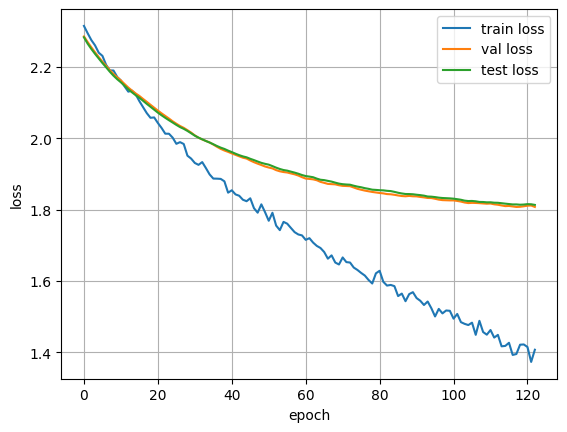

In [37]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4828431..1.2477095].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3791421..1.8025708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37057972..1.7851416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46533608..1.7851416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558

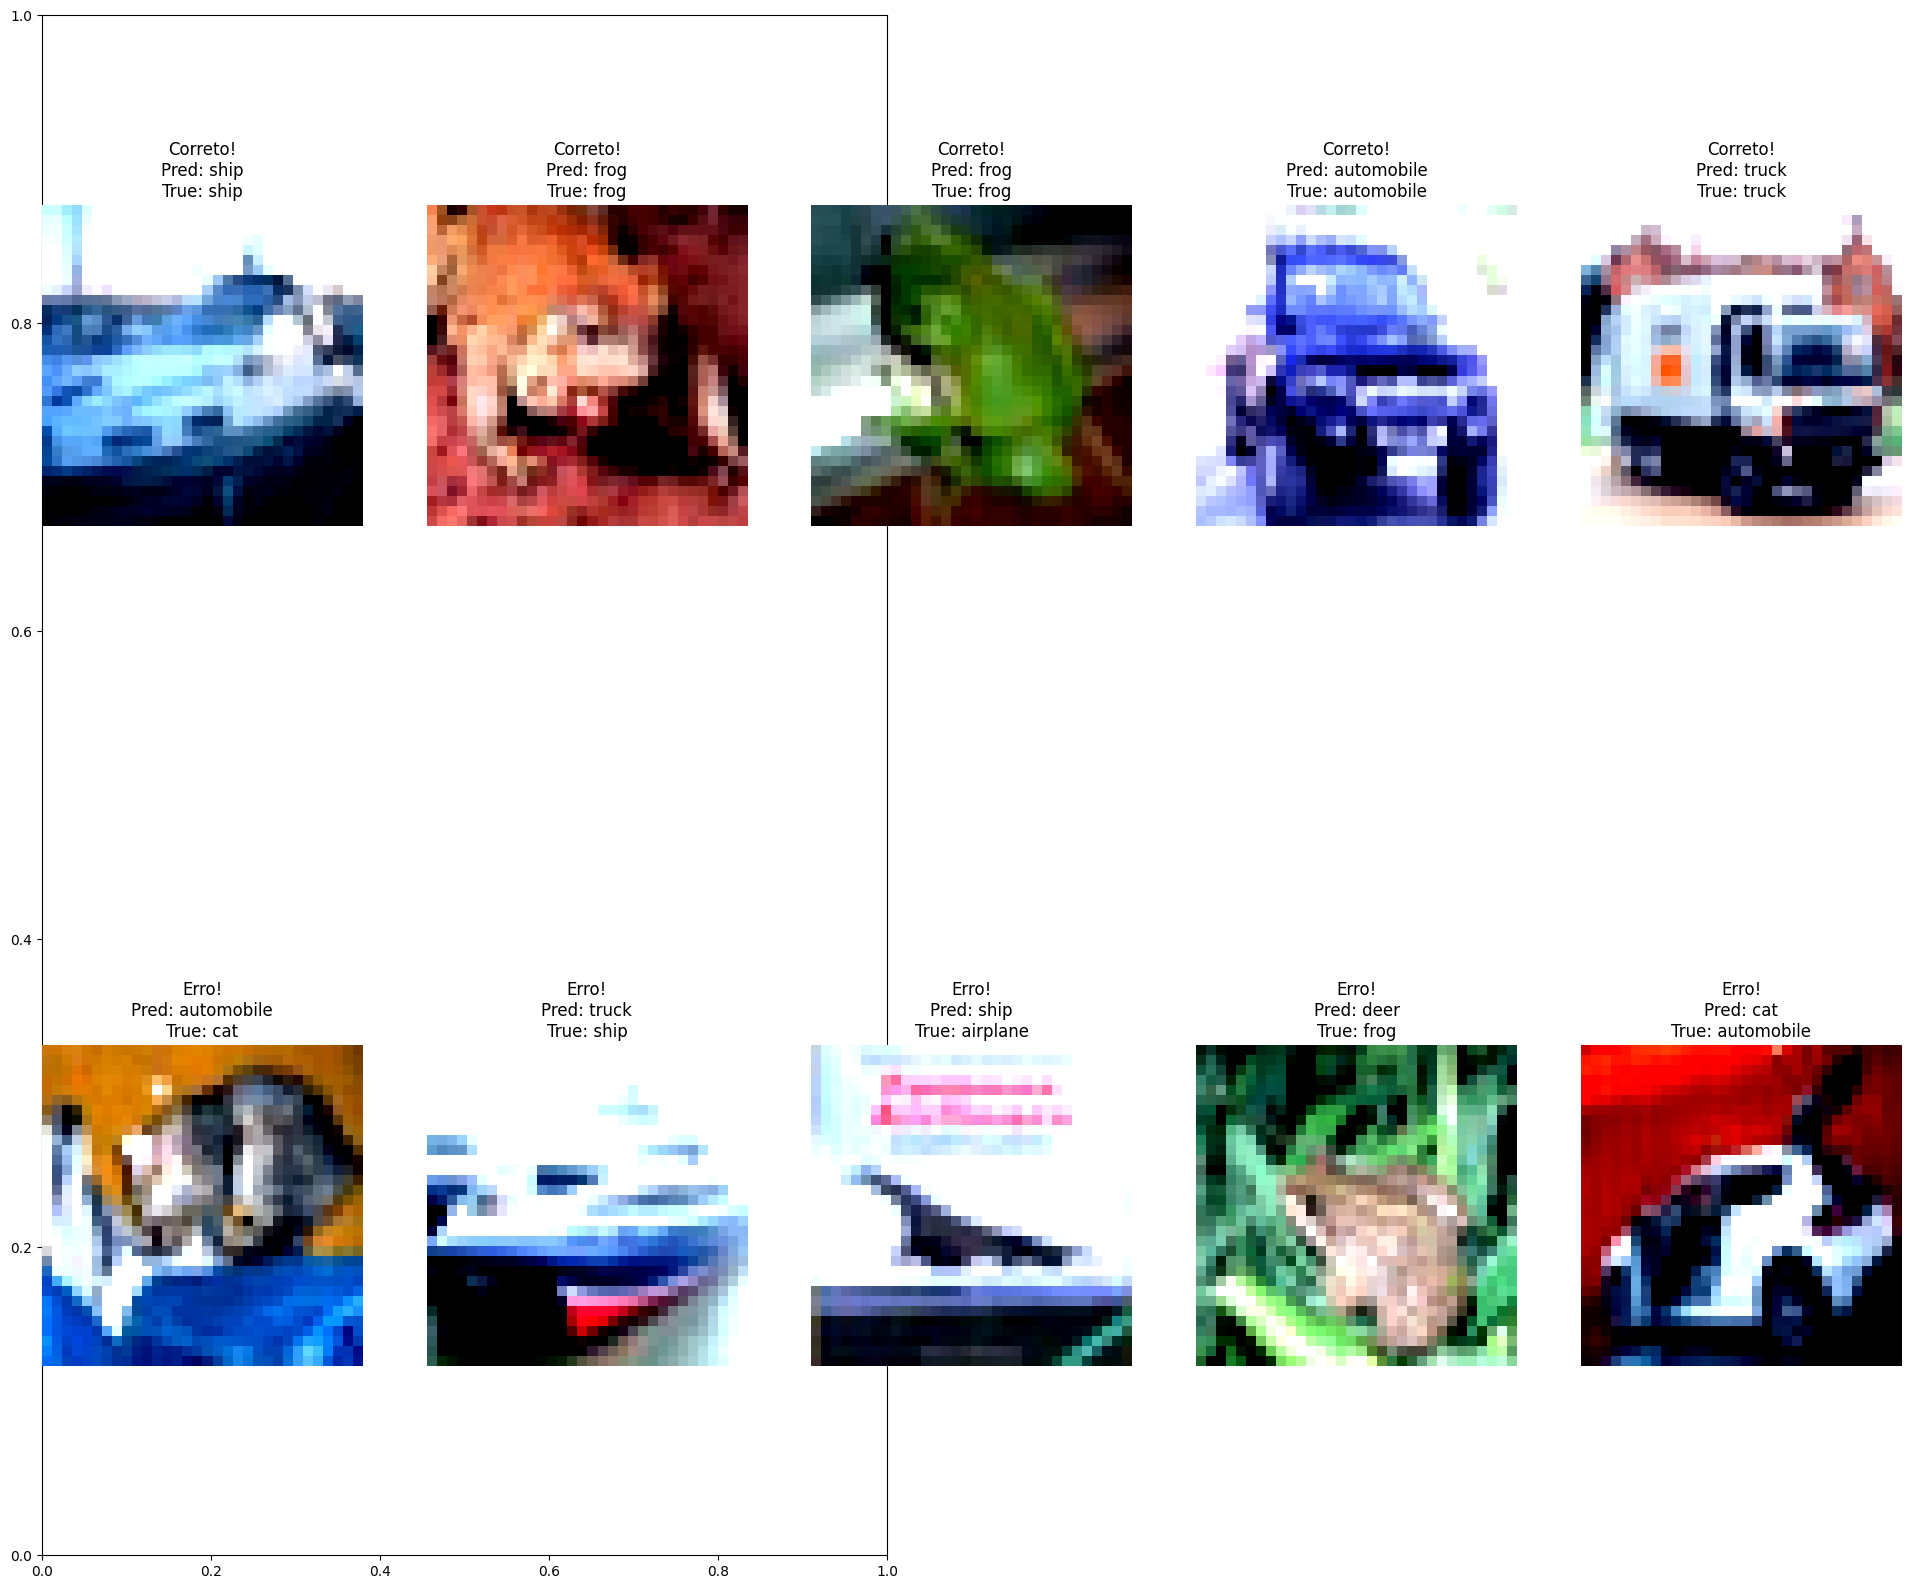

In [38]:
show_predictions(mlp, test_loader, num_samples=5)

In [48]:
mlp.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}\n\n")

Scores of your model
 {'accuracy': 0.373, 'balanced_accuracy': np.float64(0.3682872828130635), 'f1_score': 0.3599394362064536, 'precision': 0.35850809318773547, 'recall': 0.373}




In [40]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck'] # .venvNN/lib/python3.12/site-packages/torchvision/prototype/datasets/_builtin/cifar10.categories

labels = np.array(labels)
predictions = np.array(predictions)

stats = {}

print(f"\n shape dataset teste -> {len(test_dataset)}")
print("\n(repr x acc top1) por classe(conjunto teste):")

for i in range(10):
    mask = labels == i
    class_acc = np.mean(predictions[mask] == labels[mask]) * 100
    num_samples = np.sum(mask)
    class_repr = (num_samples / len(labels)) * 100

    stats[classes[i]] = {
        'acuracia': f"{class_acc:.2f}%",
        'num_amostras': num_samples,
        'representatividade': f"{class_repr:.2f}%"
    }

for classe, metricas in stats.items():
    print(f"\n{classe}:")
    print(f"  Acurácia: {metricas['acuracia']}")
    print(f"  Número de amostras: {metricas['num_amostras']}")
    print(f"  Representatividade: {metricas['representatividade']}")


 shape dataset teste -> 1000

(repr x acc top1) por classe(conjunto teste):

airplane:
  Acurácia: 33.98%
  Número de amostras: 103
  Representatividade: 10.30%

automobile:
  Acurácia: 49.44%
  Número de amostras: 89
  Representatividade: 8.90%

bird:
  Acurácia: 13.00%
  Número de amostras: 100
  Representatividade: 10.00%

cat:
  Acurácia: 15.53%
  Número de amostras: 103
  Representatividade: 10.30%

deer:
  Acurácia: 26.67%
  Número de amostras: 90
  Representatividade: 9.00%

dog:
  Acurácia: 24.42%
  Número de amostras: 86
  Representatividade: 8.60%

frog:
  Acurácia: 51.79%
  Número de amostras: 112
  Representatividade: 11.20%

horse:
  Acurácia: 47.06%
  Número de amostras: 102
  Representatividade: 10.20%

ship:
  Acurácia: 66.04%
  Número de amostras: 106
  Representatividade: 10.60%

truck:
  Acurácia: 40.37%
  Número de amostras: 109
  Representatividade: 10.90%


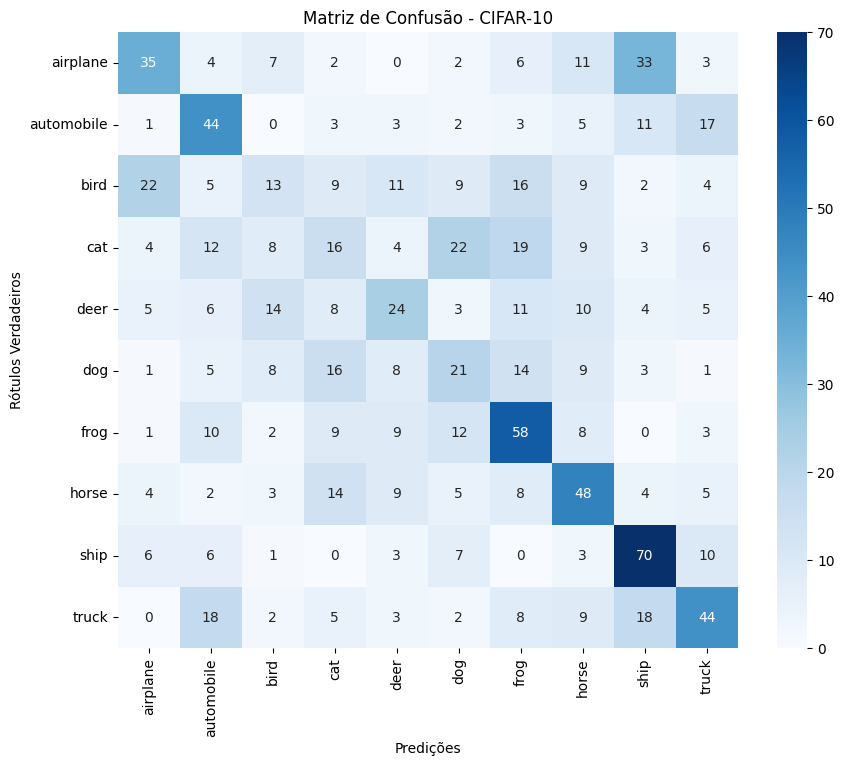

1. airplane → ship: 33 vezes
2. cat → dog: 22 vezes
3. bird → airplane: 22 vezes
4. cat → frog: 19 vezes
5. truck → ship: 18 vezes


In [47]:
cm = metrics.confusion_matrix(labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - CIFAR-10')
plt.xlabel('Predições')
plt.ylabel('Rótulos Verdadeiros')
plt.show()

cm_errors = cm.copy()
np.fill_diagonal(cm_errors, 0)

flat_indices = np.argsort(cm_errors.ravel())[::-1][:5]
confusion_indices = np.unravel_index(flat_indices, cm_errors.shape)

for i in range(5):
    true_class = confusion_indices[0][i]
    pred_class = confusion_indices[1][i]
    count = cm_errors[true_class, pred_class]
    if count > 0:
        print(f"{i+1}. {classes[true_class]} → {classes[pred_class]}: {count} vezes")